# Мэтчинг

## Описание проекта

Заказчику необходимо внедрить систему поиска товаров по запросу пользователя.

Имеются наборы данных уже преобразованных в эмбединги:
- База данных объектов (3 млн строк) - векторы размерностью 72
- Тренировочная выборка (100к строк) - векторы, имеющие лейблы (совпадающие товары из базы выше)
- Тестовая выборка (100к строк) - векторы для проверки работы алгоритма

### Цель проекта

Найти алгоритм, который находит наиболее удачные совпадения из существующей базы.

Метрикой выбрана accuracy@5, то есть алгоритм отработал удачно, если из 5 результатов предоставлен релевантный.

## План работы

Применение алгоритмов:
- Faiss
- Annoy
- Qdrant

Сопоставление результатов

## Решение

### Импорт

In [1]:
import pandas as pd
import numpy as np

import faiss

from sklearn.preprocessing import StandardScaler

import time
import json

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

### Блок функций

In [2]:
def accuracy_n(target_df, idxs):
    acc = 0
    for target, el in zip(target_df.values.tolist(), idxs.tolist()):
        acc += int(target in [base_index[r] for r in el])

    return(100 * acc / len(idxs))

### Загрузка и осмотр данных

In [3]:
base_df = pd.read_csv('datasets/base.csv',index_col=0)
display(base_df.head())
print(base_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


(2918139, 72)


In [4]:
train_df = pd.read_csv('datasets/train.csv',index_col=0)
display(train_df.head())
print(train_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


(100000, 73)


In [5]:
validation_df = pd.read_csv('datasets/validation.csv',index_col=0)
display(validation_df.head())
print(validation_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


(100000, 72)


In [6]:
validation_answer_df = pd.read_csv('datasets/validation_answer.csv',index_col=0)
display(validation_answer_df.head())
print(validation_answer_df.shape)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


(100000, 1)


### EDA

Датасеты довольно объемные, признаков довольно много, поэтому полноценный EDA сделать проблематично.

Тем не менее, мы можем оценить:
- распределения признаков
- пропущенные значения
- дубликаты

#### Проверка на дубликаты

In [7]:
print('Дубликатов в base:', base_df.duplicated().sum())
print('Дубликатов в train:', train_df.duplicated().sum())
print('Дубликатов в validation:', validation_df.duplicated().sum())
print('Дубликатов в validation_answer:', validation_answer_df.duplicated().sum())

Дубликатов в base: 0
Дубликатов в train: 0
Дубликатов в validation: 0
Дубликатов в validation_answer: 8498


Есть дубликаты в ответах валидационного датафрейма. То есть некоторые векторы val_df имеют один и тот же ответ из base_df.
Пока не будем ничего с этим делать

#### Проверка на пропущенные значения

In [8]:
train_df.isna().sum().sum()

0

In [9]:
print('Пропущенных значений в base:', base_df.isna().sum().sum())
print('Пропущенных значений в train:', train_df.isna().sum().sum())
print('Пропущенных значений в validation:', validation_df.isna().sum().sum())
print('Пропущенных значений в validation_answer:', validation_answer_df.isna().sum().sum())

Пропущенных значений в base: 0
Пропущенных значений в train: 0
Пропущенных значений в validation: 0
Пропущенных значений в validation_answer: 0


Пропусков нет

#### Проверка распределений

Оценим визуально распределения в base_df. Чтобы не просчитывать 3 млн строк, сделаем это на основе выборки в 5%

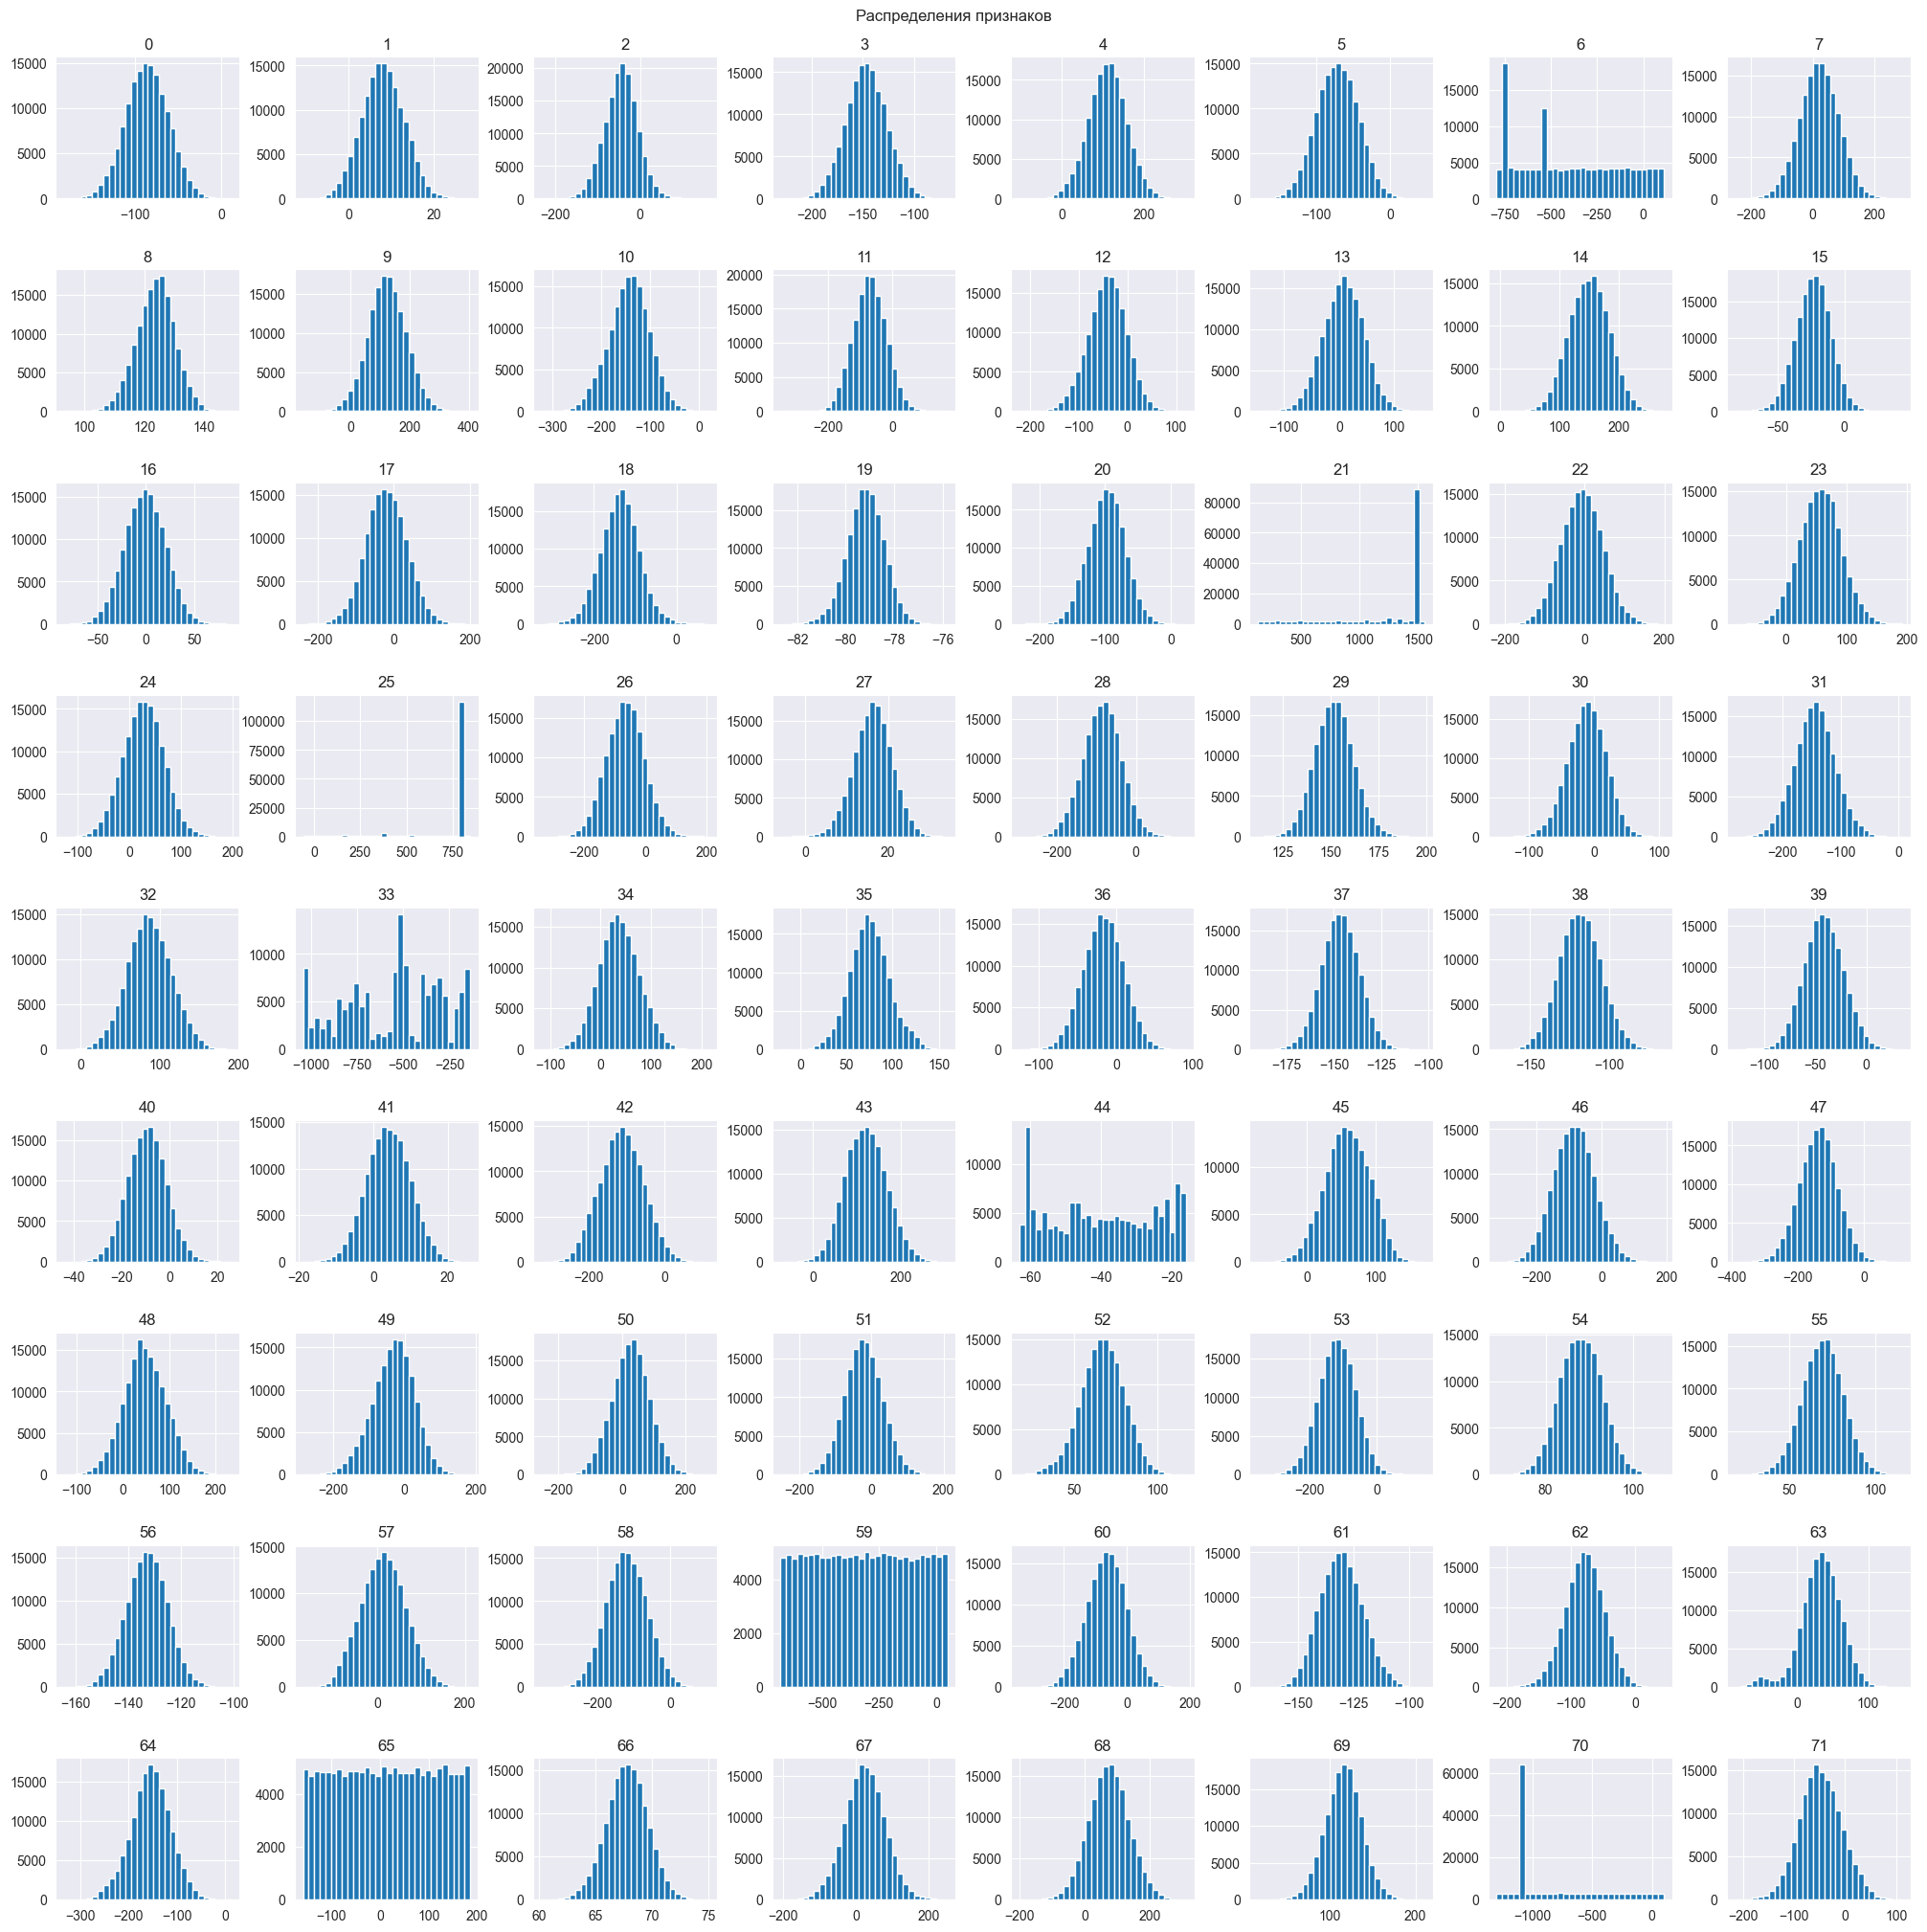

In [10]:
fig, axes = plt.subplots(nrows=9, ncols=8, figsize=(25,25))
fig.suptitle('Распределения признаков', y=0.9)
plt.subplots_adjust(hspace=0.5, wspace=0.3) # отодвигаем графики друг от друга
for i, col in enumerate(base_df.columns):
    ax = axes[i // 8, i % 8]
    ax.hist(x=base_df[col].sample(frac=0.05), bins=30)
    ax.set_ylabel('')
    ax.set_title(col)

Распределения некоторых признаков отличаются от нормального распределения. Составим список из `подозрительных` признаков. Проверим как модель будет работать с ними и без них. Если без них лучше, то удалим.

Всего признаков 72, подозратильных 8. Остается 64 признака. 

Для эмбедингов 72 признака - нетипичное значение, а 64 - типичное. Удаление этих признаков согласуется с логикой.

In [11]:
columns_to_drop = [str(i) for i in [6, 21, 25, 59, 65, 70, 33, 44]]

Значения признаков ненормированные, это нужно исправить. Но ради интереса попробуем и без этого. Помимо прочего удалим подозрительные признаки. Но снова же посмотрим какой будет от этого профит

### Предобработка данных и проверка работы FAISS

Данные уже разбиты на трейн и тест, выделяем таргеты. Также составляем словарь, где ключи - порядковые номера датафрейма `base_df` , значения - индекс(строка) в `base_df`

In [12]:
targets_train = train_df["Target"]
train_df.drop("Target", axis=1, inplace=True)
targets_val = validation_answer_df['Expected']

Составим индекс. Первым по рекомендациям разработчиков является IVF индекс с квантованием

Для начала пусть будет 1024 кластеров, по которым будет осуществляться поиск (число велико, но мы в будущем будем обходить несколько кластеров при поиске)

Увеличение числа кластеров дает бо'льшую производительность за счет точности.

Затем подберем этот гиперпараметр

In [13]:
base_index = {k: v for k, v in enumerate(base_df.index.to_list())}

In [14]:
dims = base_df.shape[1]
n_cells = 1024

Обучать индекс будем на 50000 векторов. Вероятно этого хватит, но нужно проверить.

Также составляем словарь, где ключи - порядковые номера датафрейма `base_df` , значения - индекс(строка) в `base_df`.

Вместо прописывания quantizer и index будем использовать укороченную запись при помощи `index_factory`

In [15]:
index = faiss.index_factory(dims, 'IVF1024,Flat') #quantizer c 1024 ячейками, Flat индекс с l2 метрикой
index.train(np.ascontiguousarray(base_df.values[:50000, :]).astype('float32'))
index.add(np.ascontiguousarray(base_df.values).astype('float32'))

In [16]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_df.values).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 17.2 s
Wall time: 3.55 s


4.244

Accuracy@5 чуть выше 4%. Стандартизируем векторы и запустим алгоритм заново

In [17]:
scaler = StandardScaler()
base_array = scaler.fit_transform(base_df)
train_array = scaler.fit_transform(train_df)
validation_array = scaler.transform(validation_df)

In [18]:
index = faiss.index_factory(dims, 'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:50000, :]).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))

In [19]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 21.8 s
Wall time: 4.13 s


49.679

Алгоритм отработал за 4 с небольшим секунды. Стандартизация заметно улучшает метрику.

Удалим подозрительные столбцы и проверим результат.

In [20]:
base_df.drop(columns_to_drop, axis=1, inplace=True)
train_df.drop(columns_to_drop, axis=1, inplace=True)
validation_df.drop(columns_to_drop, axis=1, inplace=True)

Стандартизируем заново

In [60]:
scaler = StandardScaler()
base_array = scaler.fit_transform(base_df)
train_array = scaler.fit_transform(train_df)
validation_array = scaler.transform(validation_df)

In [22]:
dims = base_df.shape[1] #размерность векторов изменилась, переопределим переменную

In [23]:
index = faiss.index_factory(dims, 'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:50000, :]).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))

In [24]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 18.7 s
Wall time: 3.41 s


59.733

Удаление `подозрительных` признаков улучшило метрику.

Попробуем увеличить количество кластеров для поиска `nprobe`. Время работы алгоритма при этом должно увеличиться. Предполагаю, что этот гиперпараметр будет иметь схожий эффект с гиперпараметром `n_cells` - перебор бо'льшего числа векторов при увеличении времени работы.

Заодно, для успокоения души проверим действительно ли хватает 50_000 образцов для обучения индекса. Попробуем 500_000

In [25]:
index = faiss.index_factory(dims, 'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:500_000, :]).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))
index.nprobe = 32

In [26]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 6min 30s
Wall time: 1min 15s


70.381

In [27]:
index = faiss.index_factory(dims, 'IVF1024,Flat')
index.train(np.ascontiguousarray(base_array[:50_000, :]).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))
index.nprobe = 32

In [28]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 5)
accuracy_n(targets_train, idxs)

CPU times: total: 7min 11s
Wall time: 1min 22s


70.392

2 метрики выше почти полностью совпадают. 50к достаточно для экспериментов.

Резюмируем:
- Больше кластеров по которым ищем - точнее поиск (т.к. правильный результат может быть в соседнем кластере). Время работы увеличивается линейно (на самом деле чуть быстрее, видимо, внутри лежат эффективные алгоритмы)
- 50к образцов для обучения достаточно
- Стандартизация сильно улучшает метрику

### Дальнейший план работы

Что делаем дальше. 

По уверениям разработчиков `Flat` индекс является довольно точным. Поэтому проведем эксперименты с различными гиперпараметрами этого индекса.
Но полностью на слово доверять не будем и проверим также другие индексы, если увидим результаты лучше, то проведем подбор гиперпараметров и для них тоже

Проверим следующий алгоритм:

Находим оптимальные гиперпараметры:
- Увеличиваем количество результатов поиска - от 5 до выхода на плато. `accuracy_n` увеличится, но осложнится последующая задача ранжирования.
- Увеличиваем nprobe - тут время будет расти линейно, получаем trade между скоростью работы и точностью алгоритма



Составляем матрицу:
- Каждый вектор из query конкатенируем с вектором из выдачи. То же самое проделываем для валидационной выборки
- В качестве таргета добавляем лейбл 1 или 0. Делаем так для каждого вектора из query, в итоге получаем датасет из 100_000 * idx.shape[1] строк
- Обучаем ml-модели для нахождения 1 на трейне. На выдаче получаем скоры. Следим за переобучением на валидационной выборке.
- Первые 5 скоров и будут результатом выдачи, по которым будет считаться метрика.



### Подбор гиперпараметров для FAISS

Реализуем первый шаг - найдем гиперпараметры для faiss
Пройдемся вложенным циклом и упакуем результаты в словарь. Струкрура словаря
```
metrics = {
    '5 соседей':{
        '1 кластер': [время_5_1, accuracy_train, accuracy_val], 
        '2 кластера': [время_5_2, accuracy_train, accuracy_val],
        ...,
        '128 кластеров': [время_5_2, accuracy_train, accuracy_val]
    },
    '10 соседей':{
        '1 кластер': [время_10_1, accuracy_train, accuracy_val], 
        '2 кластера': [время_10_2, accuracy_train, accuracy_val],
        ...,
        '128 кластеров': [время_10_2, accuracy_train, accuracy_val]
    },
    ...
}
```

In [29]:
# metrics = {}
# c = time.time()
# for neighbours in range(5,101,5): #ищем от 5 до 100 соседей
#     metrics[neighbours] = {}
#     for nprobe in [2**x for x in range(6)]: #ищем в разном числе кластеров
#         a = time.time()
#         index.nprobe = nprobe
#         distances_train, idxs_train = index.search(np.ascontiguousarray(train_array).astype('float32'), neighbours)
#         for i,v in enumerate(idxs_train): #заменяем -1 в ответах на 0
#             if -1 in v:
#                 idxs_train[i] = np.array([idx if idx != -1 else 0 for idx in v])
        
#         distances_val, idxs_val = index.search(np.ascontiguousarray(validation_array).astype('float32'), neighbours)
#         for i,v in enumerate(idxs_val):
#             if -1 in v:
#                 idxs_val[i] = np.array([idx if idx != -1 else 0 for idx in v])
            
#         b = time.time()
# #         отслеживаем прогресс поиска гиперпараметров с обновляемым выводом
#         print((f'\rОбработан запрос: neighbours = {neighbours},'
#                f'nprobe = {nprobe}, общее время выполнения {b-c:.2f} секунд'), end='')
#         metrics[neighbours][nprobe] = [f'Затраченное время = {(b-a)/2:.2f} секунд',\
#                                        accuracy_n(targets_train, idxs_train), accuracy_n(targets_val, idxs_val)]

Чтобы не запускать ячейку выше - сохраним результаты экспериментов в json-файл. Саму ячейку пока закомментируем (в репозитории будет раскомментирована, выполняется долго)

Вывод ячейки:
Обработан запрос: neighbours = 100,nprobe = 32, общее время выполнения 6775.33 секунд

In [30]:
# with open('datasets/metrics_faiss.json', "w", encoding="utf-8") as file:
#     json.dump(metrics, file)

In [31]:
metrics = json.load(open('datasets/metrics_faiss.json'))
metrics

{'5': {'1': ['Затраченное время = 3.71 секунд', 59.733, 59.902],
  '2': ['Затраченное время = 6.52 секунд', 65.091, 65.126],
  '4': ['Затраченное время = 11.72 секунд', 67.644, 67.735],
  '8': ['Затраченное время = 21.78 секунд', 69.125, 69.108],
  '16': ['Затраченное время = 41.04 секунд', 69.938, 69.949],
  '32': ['Затраченное время = 79.44 секунд', 70.392, 70.35]},
 '10': {'1': ['Затраченное время = 3.70 секунд', 61.364, 61.501],
  '2': ['Затраченное время = 6.55 секунд', 67.087, 67.047],
  '4': ['Затраченное время = 11.79 секунд', 69.904, 69.944],
  '8': ['Затраченное время = 21.48 секунд', 71.57, 71.539],
  '16': ['Затраченное время = 39.36 секунд', 72.518, 72.536],
  '32': ['Затраченное время = 75.66 секунд', 73.055, 73.032]},
 '15': {'1': ['Затраченное время = 3.57 секунд', 62.127, 62.259],
  '2': ['Затраченное время = 6.35 секунд', 68.007, 67.99],
  '4': ['Затраченное время = 11.27 секунд', 70.936, 70.996],
  '8': ['Затраченное время = 20.81 секунд', 72.706, 72.709],
  '16': ['

Валидация сильно не отличается. Вероятно, распределение train и val схожи. Построим графики по трейну.

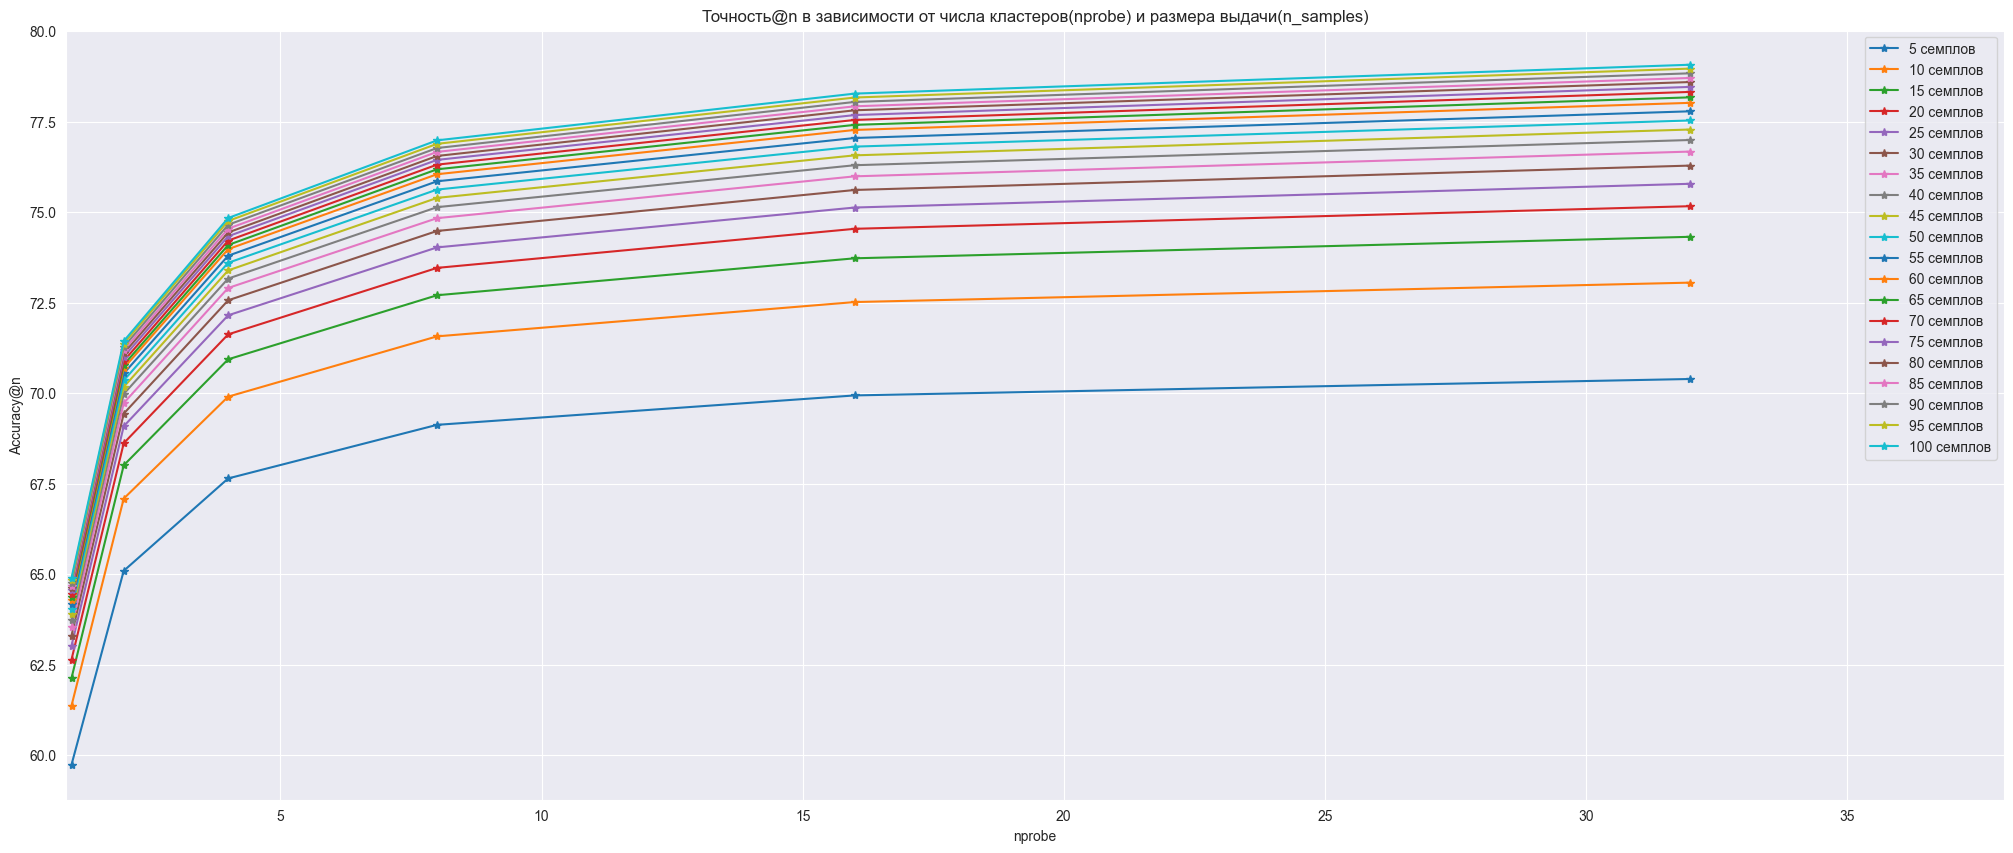

In [32]:
fig, ax = plt.subplots(1, figsize=(25, 10))
for n_samples in metrics.keys():
    y = [i[1] for i in metrics[n_samples].values()]
    x = [int(i) for i in metrics[n_samples].keys()]
    ax.plot(x,y, marker='*', label=f'{n_samples} семплов')
plt.xlim(0.9, 38)
plt.ylabel('Accuracy@n')
plt.xlabel('nprobe')
plt.title('Точность@n в зависимости от числа кластеров(nprobe) и размера выдачи(n_samples)')
ax.legend()
plt.show()

Выдача бо'льшего количества семплов не увеличивает время, но, вероятно, будет ухудшать результаты модели ранжирования (гораздо проще отобрать 5 правильных кандидатов из 30 семплов, чем 5 кандидатов из 100 семплов)

С увеличением nprobe время увеличивается линейно. Поиск по 32 кластерам не дает ощутимого прироста. Минута - ок, поэтому оставляем nprobe 16. Но если ресурсы позволят запустить в прод модель потяжелее - запустим хоть 1024(перемножим все вектора со всеми)

### Поиск оптимального индекса для задачи

Мы рассмотрели только Flat индекс с разбиением на кластеры. Посмотрим другие индексы. 

По хорошему нужно перебрать множество гиперпараметров, но в цикле по примеру выше это делать долго. Поэтому некоторые эксперименты оставлены `за кадром`. Оценивать будем с полученным бенчмарком в т.ч. и по скорости работы.

Сравнивать будем по 50 соседям и nprobe 16

In [117]:
metrics['50']['16']

['Затраченное время = 39.28 секунд', 76.813, 76.808]

#### IndexFlatIP

In [118]:
quantizer = faiss.IndexFlatIP(dims)
index = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [119]:
%%time
index.train(np.ascontiguousarray(base_array).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))
index.nprobe = 16

CPU times: total: 27.3 s
Wall time: 6.97 s


In [120]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 50)
accuracy_n(targets_train, idxs)

CPU times: total: 5min 7s
Wall time: 59.2 s


77.028

- Обучение индекса быстрое.
- Результат по сравнимому `nprobe` лучше, чем у бенчмарка
- Но за это же время мы можем перебрать в 2 раза больше кластеров у бенчмарка и получить метрику лучше

Вывод: индекс показал себя хуже

#### IVFADC Индекс

In [121]:
%%time
index = faiss.index_factory(dims, 'IVF1024,PQ16')
index.train(np.ascontiguousarray(base_array).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))
index.nprobe = 16

CPU times: total: 1min 44s
Wall time: 22.1 s


In [122]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 50)
accuracy_n(targets_train, idxs)

CPU times: total: 50 s
Wall time: 11 s


76.654

- Обучение индекса длится дольше.
- Результат по сравнимому `nprobe` хуже, чем у бенчмарка.
- Работает в 3 раза быстрее, можем перебрать больше кластеров за сопоставимое время

Вывод: кандидат на замену бенчмарку

#### HNSWFlat Индекс

Разработчики рекомендуют использовать индекс для 1М-10М датасетов. Как раз наш случай. Проверим

In [126]:
%%time
index = faiss.index_factory(dims,'IVF1024_HNSW32,Flat')
index.train(np.ascontiguousarray(base_array).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))

CPU times: total: 54.8 s
Wall time: 11.8 s


In [127]:
index.nprobe = 16

In [128]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 50)

CPU times: total: 3min 38s
Wall time: 40.2 s


In [129]:
accuracy_n(targets_train, idxs)

76.133

- Обучение заметно дольше
- Результат приблизительно тот же
- Время поиска немного дольше

Вывод: не подходит на замену, возможно, требует больше экспериментов

#### HNSW

Этот индекс быстрее. efSearch зададим больше чем 16

In [130]:
%%time
index = faiss.index_factory(dims,'HNSW')
index.train(np.ascontiguousarray(base_array).astype('float32'))
index.add(np.ascontiguousarray(base_array).astype('float32'))

CPU times: total: 13min 45s
Wall time: 2min 36s


In [145]:
index.hnsw.efSearch = 512

In [146]:
%%time
distances, idxs = index.search(np.ascontiguousarray(train_array).astype('float32'), 50)
accuracy_n(targets_train, idxs)

CPU times: total: 2min 53s
Wall time: 33.2 s


75.903

- Долгое обучение индекса
- Результат приблизительно тот же
- Время поиска немного быстрее

Вывод: нет очевидной разницы, возможно, требует больше экспериментов